In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set(style="whitegrid")

IMPORT DATA and conduct initial exploratory analysis

In [3]:
# Load data
train = pd.read_csv('../data/raw/train.csv', parse_dates=['date'])
test = pd.read_csv('../data/raw/test.csv')
sample_submission =pd.read_csv('../data/raw/sample_submission.csv')

# Preview
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (913000, 4)
Test shape: (45000, 4)


In [4]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [6]:
train.describe()

,date,store,item,sales
count,913000,913000.000000,913000.000000,913000.000000
mean,2015-07-02 11:59:59.999999744,5.500000,25.500000,52.250287
min,2013-01-01 00:00:00,1.000000,1.000000,0.000000
25%,2014-04-02 00:00:00,3.000000,13.000000,30.000000
50%,2015-07-02 12:00:00,5.500000,25.500000,47.000000
75%,2016-10-01 00:00:00,8.000000,38.000000,70.000000
max,2017-12-31 00:00:00,10.000000,50.000000,231.000000
std,NaN,2.872283,14.430878,28.801144


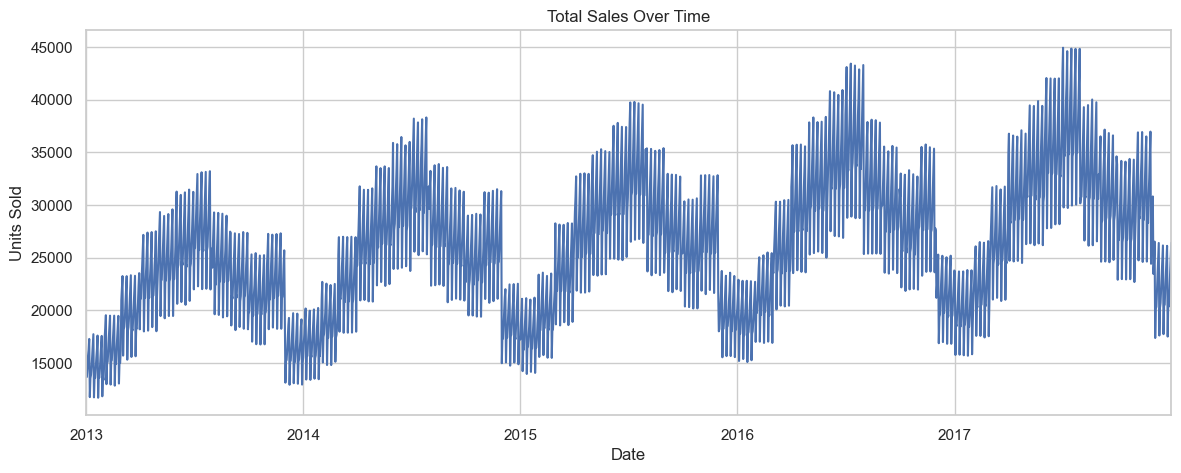

In [7]:
#Plot total demand over time
train.groupby('date')['sales'].sum().plot(figsize=(14, 5), title='Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.show()

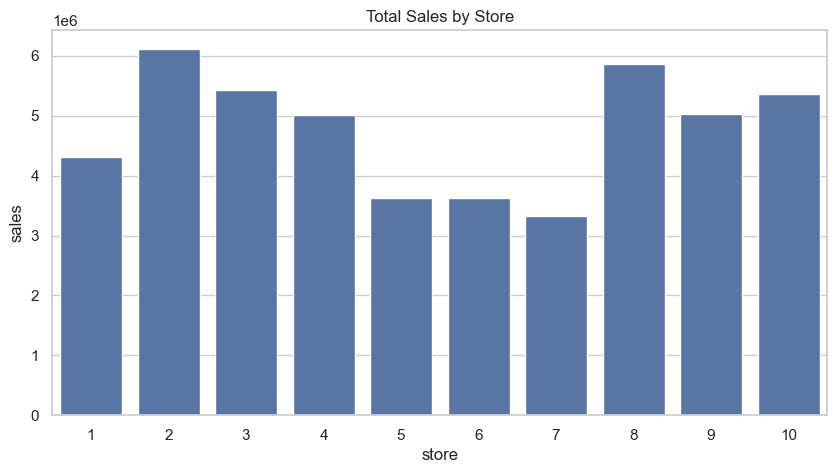

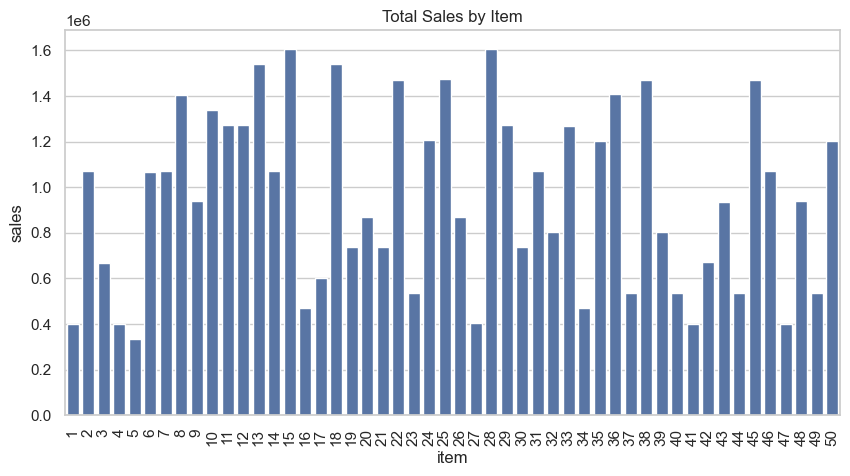

In [8]:
#Plot sales by store and item
plt.figure(figsize=(10, 5))
sns.barplot(data=train.groupby('store')['sales'].sum().reset_index(), x='store', y='sales')
plt.title('Total Sales by Store')
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=train.groupby('item')['sales'].sum().reset_index().sort_values('sales', ascending=False), x='item', y='sales')
plt.title('Total Sales by Item')
plt.xticks(rotation=90)
plt.show()

In [9]:
#Feature engineering
# Sort values to ensure correct lag calculation
train = train.sort_values(by=['store', 'item', 'date'])

# Create lag features
train['lag_1'] = train.groupby(['store', 'item'])['sales'].shift(1)
train['lag_7'] = train.groupby(['store', 'item'])['sales'].shift(7)
train['lag_14'] = train.groupby(['store', 'item'])['sales'].shift(14)
train['lag_28'] = train.groupby(['store', 'item'])['sales'].shift(28)

# Create rolling statistics features (using shifted sales to avoid data leakage)
train['rolling_mean_7'] = train.groupby(['store', 'item'])['sales'].shift(1).rolling(window=7).mean()
train['rolling_mean_14'] = train.groupby(['store', 'item'])['sales'].shift(1).rolling(window=14).mean()
train['rolling_mean_30'] = train.groupby(['store', 'item'])['sales'].shift(1).rolling(window=30).mean()
train['rolling_std_7'] = train.groupby(['store', 'item'])['sales'].shift(1).rolling(window=7).std()

# Add date/time features
train['day_of_week'] = train['date'].dt.dayofweek
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['is_weekend'] = train['day_of_week'].isin([5, 6]).astype(int)

# Drop rows with NaN values (due to shifting/rolling)
train = train.dropna().reset_index(drop=True)

# Preview to confirm
print("Feature engineering complete. Sample:")
train.head()

Feature engineering complete. Sample:


,date,store,item,sales,lag_1,lag_7,lag_14,lag_28,rolling_mean_7,rolling_mean_14,rolling_mean_30,rolling_std_7,day_of_week,month,year,is_weekend
0,2013-01-31,1,1,13,9.0,8.0,16.0,14.0,10.285714,10.857143,10.500000,2.751623,3,1,2013,0
1,2013-02-01,1,1,11,13.0,14.0,7.0,13.0,11.000000,10.642857,10.500000,2.708013,4,2,2013,0
2,2013-02-02,1,1,21,11.0,12.0,18.0,10.0,10.571429,10.928571,10.500000,2.370453,5,2,2013,1
3,2013-02-03,1,1,15,21.0,12.0,15.0,12.0,11.857143,11.142857,10.733333,4.634241,6,2,2013,1
4,2013-02-04,1,1,14,15.0,11.0,8.0,10.0,12.285714,11.142857,10.800000,4.785892,0,2,2013,0


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define features and target
feature_cols = [
    'lag_1', 'lag_7', 'lag_14', 'lag_28',
    'rolling_mean_7', 'rolling_mean_14', 'rolling_mean_30', 'rolling_std_7',
    'day_of_week', 'month', 'year', 'is_weekend'
]

X = train[feature_cols]
y = train['sales']

# Time-based train/validation split: last 30 days = validation
cutoff_date = train['date'].max() - pd.Timedelta(days=30)
X_train = X[train['date'] <= cutoff_date]
y_train = y[train['date'] <= cutoff_date]
X_val = X[train['date'] > cutoff_date]
y_val = y[train['date'] > cutoff_date]

In [11]:
# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_val)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_val)

In [12]:
# Define evaluation function
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Results:")
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("R²:", r2_score(y_true, y_pred))

# 6. Evaluate both models
evaluate_model("Linear Regression", y_val, lr_preds)
evaluate_model("Random Forest", y_val, rf_preds)


Linear Regression Results:
RMSE: 9.436001103726026
MAE: 7.081191017331754
R²: 0.826132119991852

Random Forest Results:
RMSE: 7.944005102801316
MAE: 6.072158
R²: 0.8767683051207927


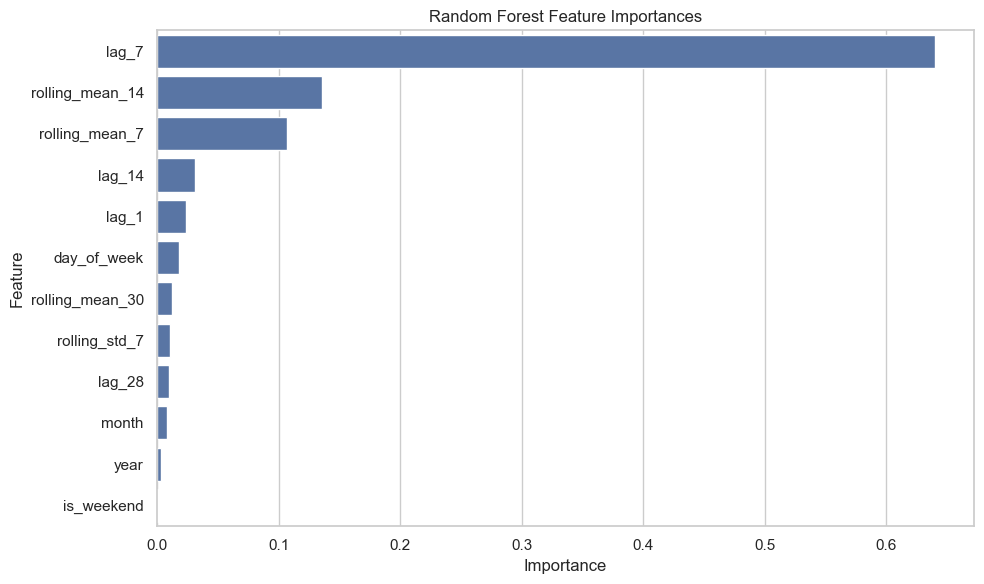

In [13]:
# Get feature importances from the trained random forest model
importances = rf_model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()

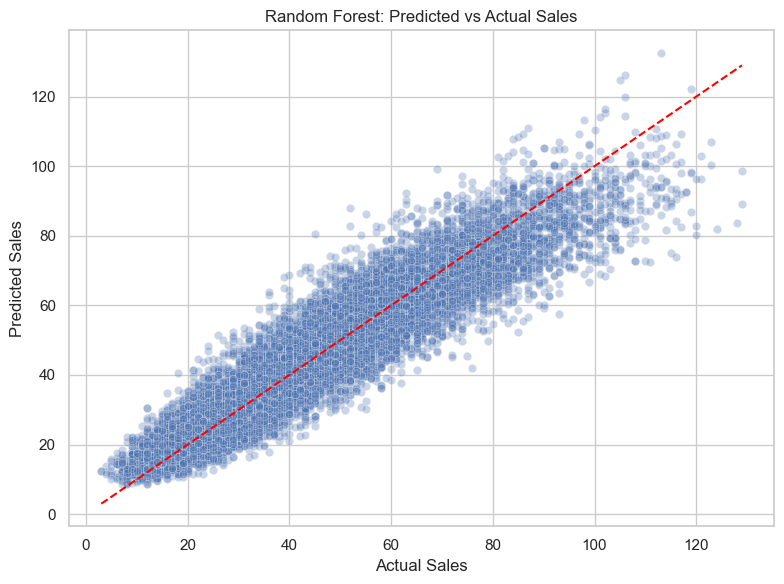

In [14]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=rf_preds, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Random Forest: Predicted vs Actual Sales")
plt.tight_layout()
plt.show()

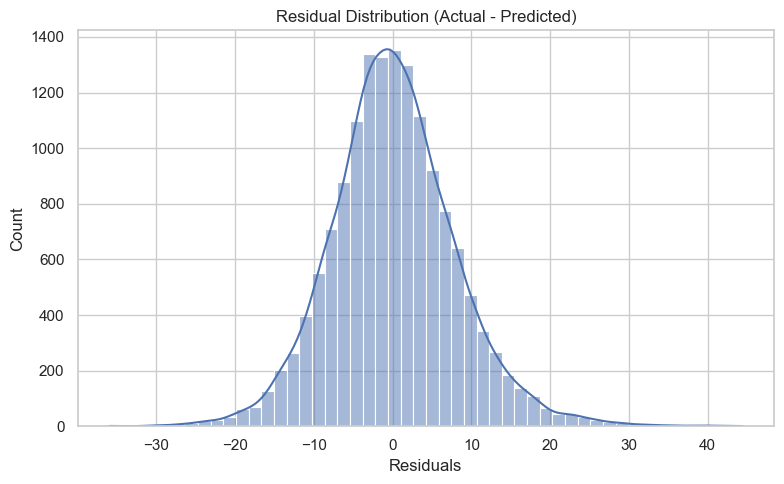

In [15]:
residuals = y_val - rf_preds

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residual Distribution (Actual - Predicted)")
plt.xlabel("Residuals")
plt.tight_layout()
plt.show()

In [33]:
#Hyperparameter tuning for random forest

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, root_mean_squared_error
import numpy as np

# Define RMSE as a scoring function using the updated method
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# Parameter space
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt','log2', None]
}

# Randomized Search
rf = RandomForestRegressor(random_state=42)
search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,
    scoring=rmse_scorer,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
search.fit(X_train, y_train)

# Best model
best_rf = search.best_estimator_

# Evaluate on validation set
from sklearn.metrics import root_mean_squared_error
rmse = root_mean_squared_error(y_val, best_rf.predict(X_val))

print(f"\nBest Parameters: {search.best_params_}")
print(f"Validation RMSE: {rmse:.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best Parameters: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None}
Validation RMSE: 7.8227


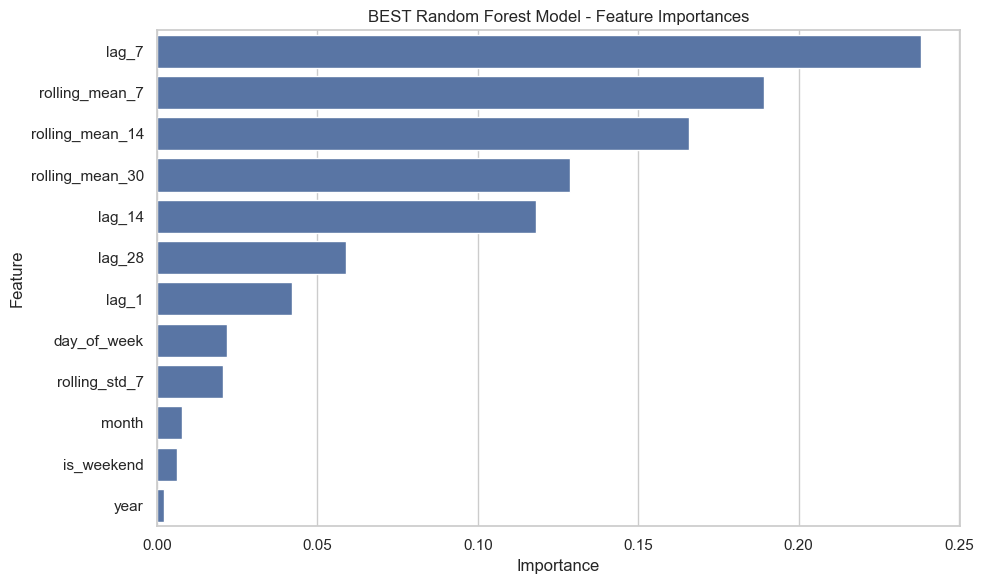

In [40]:
# Get feature importances from the BEST random forest model
importances = best_rf.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('BEST Random Forest Model - Feature Importances')
plt.tight_layout()
plt.show()

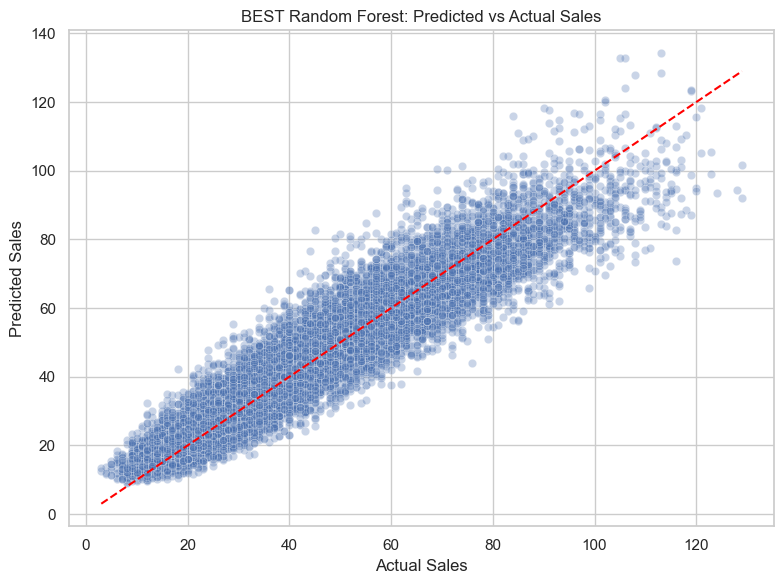

In [44]:
best_rf_preds = best_rf.predict(X_val)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=best_rf_preds, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("BEST Random Forest: Predicted vs Actual Sales")
plt.tight_layout()
plt.show()

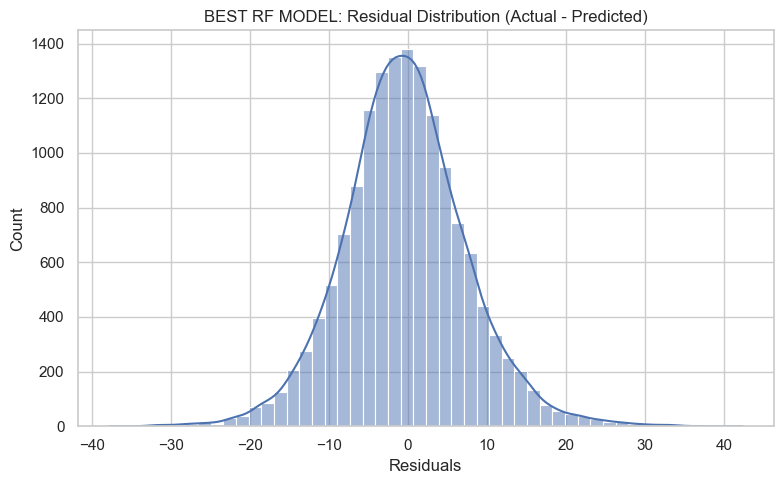

In [46]:
residuals = y_val - best_rf_preds

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=50, kde=True)
plt.title("BEST RF MODEL: Residual Distribution (Actual - Predicted)")
plt.xlabel("Residuals")
plt.tight_layout()
plt.show()

Try using different models for each store

In [67]:
# Include all engineered features + 'store'
feature_cols = [col for col in train.columns if col not in ['sales', 'date', 'id']]

# Recreate train/val splits
X = train[feature_cols]
y = train['sales']

# Time-based train/validation split: last 30 days = validation
cutoff_date = train['date'].max() - pd.Timedelta(days=30)
X_train = X[train['date'] <= cutoff_date]
y_train = y[train['date'] <= cutoff_date]
X_val = X[train['date'] > cutoff_date]
y_val = y[train['date'] > cutoff_date]

In [69]:
X_train.head()

,store,item,lag_1,lag_7,lag_14,lag_28,rolling_mean_7,rolling_mean_14,rolling_mean_30,rolling_std_7,day_of_week,month,year,is_weekend
0,1,1,9.0,8.0,16.0,14.0,10.285714,10.857143,10.500000,2.751623,3,1,2013,0
1,1,1,13.0,14.0,7.0,13.0,11.000000,10.642857,10.500000,2.708013,4,2,2013,0
2,1,1,11.0,12.0,18.0,10.0,10.571429,10.928571,10.500000,2.370453,5,2,2013,1
3,1,1,21.0,12.0,15.0,12.0,11.857143,11.142857,10.733333,4.634241,6,2,2013,1
4,1,1,15.0,11.0,8.0,10.0,12.285714,11.142857,10.800000,4.785892,0,2,2013,0


In [73]:
stores = train['store'].unique()
store_models = {}
store_metrics = {}

In [75]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

for store_id in stores:
    print(f"Training model for Store {store_id}...")
    
    # Filter train and validation data for the store
    X_store_train = X_train[X_train['store'] == store_id].drop('store', axis=1)
    y_store_train = y_train[X_train['store'] == store_id]

    X_store_val = X_val[X_val['store'] == store_id].drop('store', axis=1)
    y_store_val = y_val[X_val['store'] == store_id]

    # Train model
    model = RandomForestRegressor(
        n_estimators=150,
        min_samples_split=5,
        min_samples_leaf=4,
        max_features='sqrt',
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_store_train, y_store_train)

    # Predict and store metrics
    preds = model.predict(X_store_val)
    rmse = np.sqrt(mean_squared_error(y_store_val, preds))
    mae = mean_absolute_error(y_store_val, preds)
    r2 = r2_score(y_store_val, preds)

    store_models[store_id] = model
    store_metrics[store_id] = {'RMSE': rmse, 'MAE': mae, 'R²': r2}

    print(f"Store {store_id} — RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    rmse_avg = np.mean([m['RMSE'] for m in store_metrics.values()])
    mae_avg = np.mean([m['MAE'] for m in store_metrics.values()])
    r2_avg = np.mean([m['R²'] for m in store_metrics.values()])

    print(f"\nAverage across all stores — RMSE: {rmse_avg:.4f}, MAE: {mae_avg:.4f}, R²: {r2_avg:.4f}")

Training model for Store 1...
Store 1 — RMSE: 7.7871, MAE: 5.9546, R²: 0.8274

Average across all stores — RMSE: 7.7871, MAE: 5.9546, R²: 0.8274
Training model for Store 2...
Store 2 — RMSE: 9.4304, MAE: 7.2289, R²: 0.8684

Average across all stores — RMSE: 8.6088, MAE: 6.5918, R²: 0.8479
Training model for Store 3...
Store 3 — RMSE: 8.6836, MAE: 6.7517, R²: 0.8581

Average across all stores — RMSE: 8.6337, MAE: 6.6451, R²: 0.8513
Training model for Store 4...
Store 4 — RMSE: 8.1864, MAE: 6.3403, R²: 0.8577

Average across all stores — RMSE: 8.5219, MAE: 6.5689, R²: 0.8529
Training model for Store 5...
Store 5 — RMSE: 6.9994, MAE: 5.4777, R²: 0.8075

Average across all stores — RMSE: 8.2174, MAE: 6.3506, R²: 0.8438
Training model for Store 6...
Store 6 — RMSE: 6.9578, MAE: 5.3234, R²: 0.7965

Average across all stores — RMSE: 8.0075, MAE: 6.1794, R²: 0.8359
Training model for Store 7...
Store 7 — RMSE: 6.5442, MAE: 5.1094, R²: 0.8006

Average across all stores — RMSE: 7.7984, MAE: 6.02

Whilst there is variation by store, this approach does not include the model performance overall (if I had longer I would try and tune them though) so will stick with the overall tuned Random Forest model for now.

As a final check, try an XGBoost approach

In [110]:
X_train_xgb = X_train.drop(columns=['store', 'item'])
X_val_xgb = X_val.drop(columns=['store', 'item'])

In [81]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [112]:
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialize model
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Train
xgb_model.fit(X_train_xgb, y_train)

# Predict
xgb_preds = xgb_model.predict(X_val_xgb)

# Evaluate
rmse = root_mean_squared_error(y_val, xgb_preds)
mae = mean_absolute_error(y_val, xgb_preds)
r2 = r2_score(y_val, xgb_preds)

print(f"XGBoost Results:\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}\nR²: {r2:.4f}")

XGBoost Results:
RMSE: 9.6958
MAE: 7.4043
R²: 0.8164


Try tuning the XGBoost model

In [115]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, root_mean_squared_error

# RMSE scorer (negative because higher scores are better in sklearn)
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}


In [119]:
xgb = XGBRegressor(random_state=42, n_jobs=-1)

xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,           # keep this small for faster tuning
    scoring=rmse_scorer,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_train_xgb, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 6, 8],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42,
                   scoring=make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict'),
                   verbose=1)

In [123]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# Get the best model from the search
best_xgb = xgb_search.best_estimator_

# Predict on validation set
xgb_tuned_preds = best_xgb.predict(X_val_xgb)

# Evaluate
rmse = root_mean_squared_error(y_val, xgb_tuned_preds)
mae = mean_absolute_error(y_val, xgb_tuned_preds)
r2 = r2_score(y_val, xgb_tuned_preds)

print("Tuned XGBoost Results:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

Tuned XGBoost Results:
RMSE: 10.6685
MAE: 8.3227
R²: 0.7777


Try a light GBM approach

In [99]:
pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [126]:
from lightgbm import LGBMRegressor

# Initialize LightGBM Regressor
lgb_model = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Train
lgb_model.fit(X_train_xgb, y_train)

# Predict
lgb_preds = lgb_model.predict(X_val_xgb)

# Evaluate
rmse = root_mean_squared_error(y_val, lgb_preds)
mae = mean_absolute_error(y_val, lgb_preds)
r2 = r2_score(y_val, lgb_preds)

print("LightGBM Results:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1807
[LightGBM] [Info] Number of data points in the train set: 883000, number of used features: 12
[LightGBM] [Info] Start training from score 52.766276
LightGBM Results:
RMSE: 9.9965
MAE: 7.7231
R²: 0.8049


Compare best results so far

In [133]:
# Predictions
rf_preds = best_rf.predict(X_val_xgb)
xgb_preds = best_xgb.predict(X_val_xgb)
lgb_preds = lgb_model.predict(X_val_xgb)

In [137]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

# Compute metrics
results = {
    "Model": ["Tuned Random Forest", "Tuned XGBoost", "LightGBM"],
    "RMSE": [
        root_mean_squared_error(y_val, rf_preds),
        root_mean_squared_error(y_val, xgb_preds),
        root_mean_squared_error(y_val, lgb_preds)
    ],
    "MAE": [
        mean_absolute_error(y_val, rf_preds),
        mean_absolute_error(y_val, xgb_preds),
        mean_absolute_error(y_val, lgb_preds)
    ],
    "R²": [
        r2_score(y_val, rf_preds),
        r2_score(y_val, xgb_preds),
        r2_score(y_val, lgb_preds)
    ]
}

# Display as a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

                 Model       RMSE       MAE        R²
0  Tuned Random Forest   7.822715  6.002766  0.880503
1        Tuned XGBoost  10.668477  8.322661  0.777747
2             LightGBM   9.996479  7.723092  0.804864
